# Обучение без учителя: уменьшение размерности и кластеризация

Основное отличие методов обучения без учителя от привычных классификаций и регрессий машинного обучения в том, что разметки для данных в этом случае нет. От этого образуются сразу несколько особенностей — во-первых это возможность использования несопоставимо больших объёмов данных, поскольку их не нужно будет размечать руками для обучения, а во-вторых это неясность измерения качества методов, из-за отсутствия таких же прямолинейных и интуитивно понятных метрик, как в задачах обучения с учителем.

Одна из возможных задач — это понижение размерности в даных, например, для визуализации. С другой стороны, такая задача позволяет убрать из наблюдений сильно скоррелированные признаки, что облегчит дальнейшее построение модели.

## Метод главных компонент (PCA)

Метод главных компонент — один из самых часто используемых подходов для снижения размерности данных.

В совсем общем виде это можно представить как предположение о том, что все наши наблюдения скорее всего выглядят как некий эллипсоид в подпространстве нашего исходного пространства и наш новый базис в этом пространстве совпадает с осями этого эллипсоида. Это предположение позволяет нам одновременно избавиться от сильно скоррелированных признаков, так как вектора базиса пространства, на которое мы проецируем, будут ортогональными.

<center>
    <img width=500 src='images/pca.png'>   
</center>

В общем случае размерность этого эллипсоида будет равна размерности исходного пространства, но наше предположение о том, что данные лежат в подпространстве меньшей размерности, позволяет нам отбросить "лишнее" подпространство в новой проекции, а именно то подпространство, вдоль осей которого эллипсоид будет наименее растянут. Мы будем это делать "жадно", выбирая по-очереди в качестве нового элемента базиса нашего нового подпространства последовательно ось эллипсоида из оставшихся, вдоль которой дисперсия будет максимальной.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import decomposition
from sklearn import datasets

%matplotlib inline

In [5]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X.shape

(150, 4)

Применим `PCA` к ирисам, чтобы отобразить их на графике

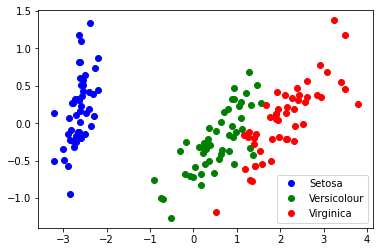

In [6]:
pca = decomposition.PCA(n_components=2, random_state=7)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Setosa')
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'go', label='Versicolour')
plt.plot(X_pca[y == 2, 0], X_pca[y == 2, 1], 'ro', label='Virginica')
plt.legend(loc=0);

`PCA` так же можно использовать перед обучением моделей, чтобы "облегчить" им поиск знакономерностей в данных.

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=7, shuffle=True)

clf = DecisionTreeClassifier(max_depth=2, random_state=7)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy before PCA: {:.5f}'.format(accuracy_score(y_test, y_pred)))

Accuracy before PCA: 0.88889


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.3, stratify=y, random_state=7, shuffle=True)

clf = DecisionTreeClassifier(max_depth=2, random_state=7)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy after PCA: {:.5f}'.format(accuracy_score(y_test, y_pred)))

Accuracy after PCA: 0.91111


Видно, что качество возросло незначительно, но для более сложных данных более высокой размерности, где данные не разбиваются тривиально вдоль одного признака, применение PCA может достаточно сильно улучшить качество работы деревьев решений и ансамблей на их основе.

`sklearn` позволяет заглянуть внутрь модели и посмотреть, какой процент диспресии объясняет каждая компонента.

In [9]:
for i, component in enumerate(pca.components_):
    print(f"{i + 1} component: {round(100 * pca.explained_variance_ratio_[i], 2)}% of initial variance")
    print("this component is combination of:")
    print(" + ".join(f"{round(value, 3)} x {name}" for value, name in zip(component, iris.feature_names)))
    print("=" * 20)

1 component: 92.46% of initial variance
this component is combination of:
0.361 x sepal length (cm) + -0.085 x sepal width (cm) + 0.857 x petal length (cm) + 0.358 x petal width (cm)
2 component: 5.31% of initial variance
this component is combination of:
0.657 x sepal length (cm) + 0.73 x sepal width (cm) + -0.173 x petal length (cm) + -0.075 x petal width (cm)


## Рукописные цифры

Посмотрим на чуть более сложный пример

(1797, 64)


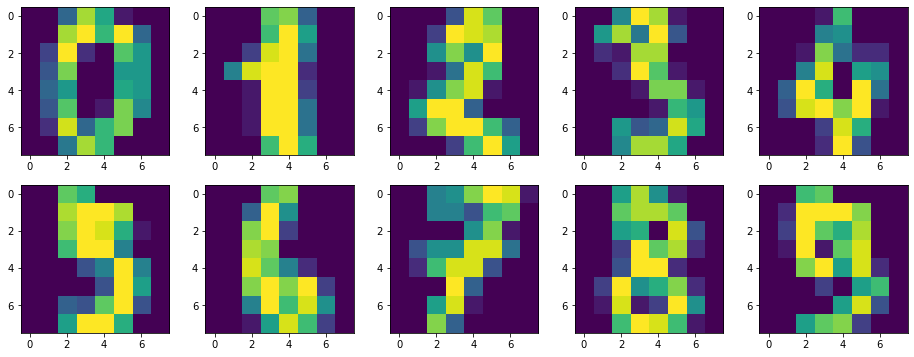

In [10]:
digits = datasets.load_digits()
X = digits.data
y = digits.target

print(X.shape)

plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8,8]));

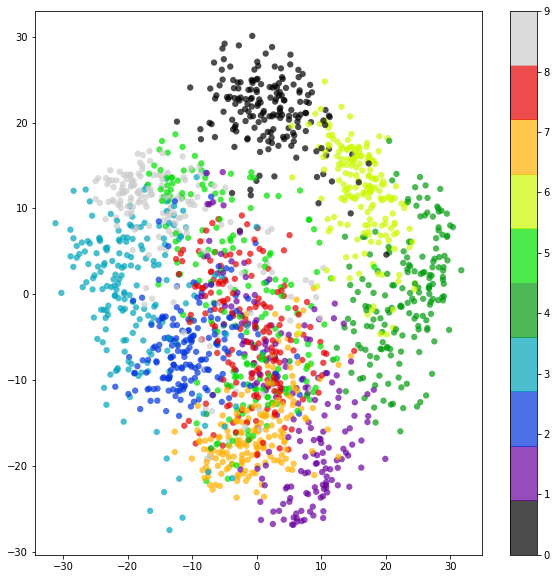

CPU times: user 856 ms, sys: 486 ms, total: 1.34 s
Wall time: 358 ms


In [11]:
%%time
# исходная размерность -- 64, снизим до 2

pca = decomposition.PCA(n_components=2, random_state=7)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

Альтернативой к `PCA` может служить алгоритм `t-SNE`. Зачастую он работает лучше, но и дольше.

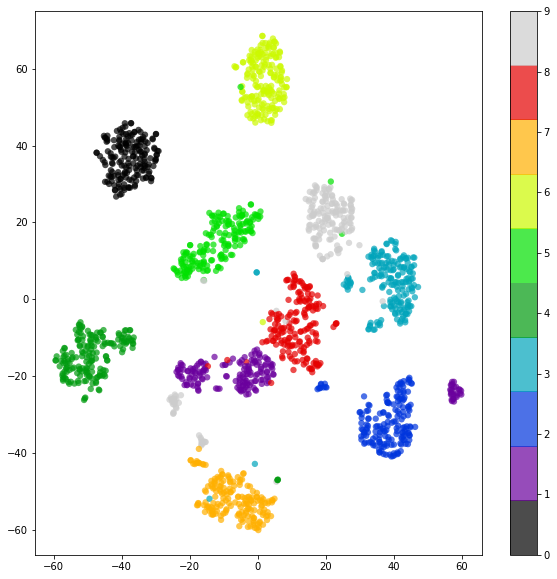

CPU times: user 31.6 s, sys: 34.8 ms, total: 31.7 s
Wall time: 4.45 s


In [12]:
%%time

from sklearn.manifold import TSNE
tsne = TSNE(random_state=7)

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y,edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

На практике, как правило, выбирают столько главных компонент, чтобы оставить 90% дисперсии исходных данных. В данном случае для этого достаточно выделить 21 главную компоненту, то есть снизить размерность с 64 признаков до 21.

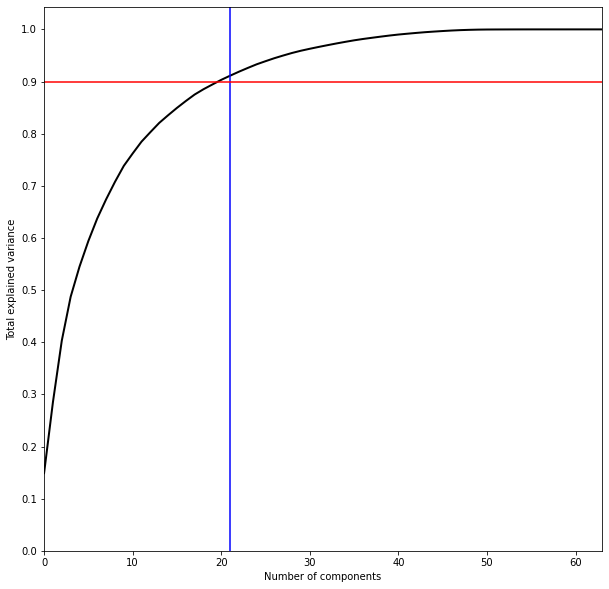

In [13]:
pca = decomposition.PCA(random_state=7)
pca.fit(X)

plt.figure(figsize=(10, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(21, c='b')
plt.axhline(0.9, c='r')
plt.show();

# Кластеризация

Интуитивная постановка задачи кластеризации довольно проста и представляет из себя наше желание сказать: "Вот тут у меня насыпаны точки. Я вижу, что они сваливаются в какие-то кучки вместе. Было бы круто иметь возможность эти точки относить к кучкам и в случае появления новой точки на плоскости говорить, в какую кучку она падает." Из такой постановки видно, что пространства для фантазии получается много, и от этого возникает соответствующее множество алгоритмов решения этой задачи. Вот несколько самых популярных:

<center>
    <img src="images/clusterings.png">
</center>

## K-means

Самый популярный и простой алгоритм кластеризации, его очень легко представить в виде последовательности шагов:

1. Выбрать количество кластеров $k$, которое нам кажется оптимальным для наших данных.
2. Высыпать случайным образом в пространство наших данных $k$ точек (центроидов).
3. Для каждой точки нашего набора данных посчитать, к какому центроиду она ближе.
4. Переместить каждый центроид в центр выборки, которую мы отнесли к этому центроиду.
5. Повторять последние два шага фиксированное число раз, либо до тех пор пока центроиды не "сойдутся" (обычно это значит, что их смещение относительно предыдущего положения не превышает какого-то заранее заданного небольшого значения).

В случае обычной евклидовой метрики для точек лежащих на плоскости, этот алгоритм очень просто расписывается аналитически и рисуется. Давайте посмотрим соответствующий пример:

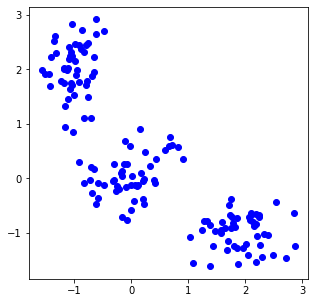

In [14]:
# Начнём с того, что насыпем на плоскость три кластера точек
X = np.zeros((150, 2))

np.random.seed(seed=7)
X[:50, 0] = np.random.normal(loc=0.0, scale=.4, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.4, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.3, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.3, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

plt.figure(figsize=(5, 5))
plt.plot(X[:, 0], X[:, 1], 'bo')

In [15]:
# В scipy есть замечательная функция, которая считает расстояния
# между парами точек из двух массивов, подающихся ей на вход
from scipy.spatial.distance import cdist

# насыпем три случайные центроиды для начала
np.random.seed(7)
centroids = np.random.normal(loc=0.0, scale=1., size=6)
centroids = centroids.reshape((3, 2))

cent_history = []
cent_history.append(centroids)

for i in range(3):
    # Считаем расстояния от наблюдений до центроид
    distances = cdist(X, centroids)
    # Смотрим, до какой центроиде каждой точке ближе всего
    labels = distances.argmin(axis=1)
    
    # Положим в каждую новую центроиду геометрический центр её точек
    centroids = centroids.copy()
    centroids[0, :] = np.mean(X[labels == 0, :], axis=0)
    centroids[1, :] = np.mean(X[labels == 1, :], axis=0)
    centroids[2, :] = np.mean(X[labels == 2, :], axis=0)
    
    cent_history.append(centroids)

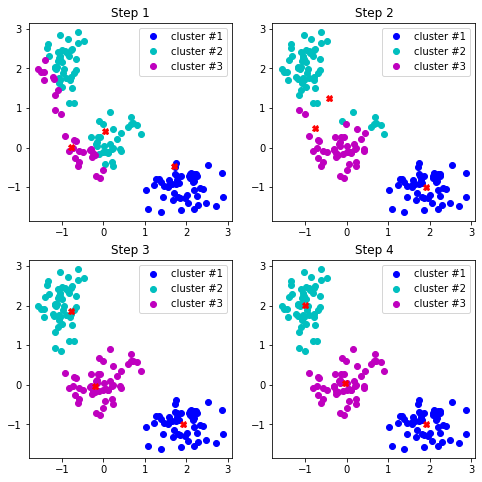

In [16]:
plt.figure(figsize=(8, 8))
for i in range(4):
    distances = cdist(X, cent_history[i])
    labels = distances.argmin(axis=1)
    
    plt.subplot(2, 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    plt.legend(loc=0)
    plt.title('Step {:}'.format(i + 1));

Также стоит заметить, что хоть мы и рассматривали евклидово расстояние, алгоритм будет сходиться и в случае любой другой метрики, поэтому для различных задач кластеризации в зависимости от данных можно экспериментировать не только с количеством шагов или критерием сходимости, но и с метрикой, по которой мы считаем расстояния между точками и центроидами кластеров.

Другой особенностью этого алгоритма является то, что он чувствителен к исходному положению центроид кластеров в пространстве. В такой ситуации спасает несколько последовательных запусков алгоритма с последующим усреднением полученных кластеров.

## Выбор оптимального числа кластеров (правило "локтя")

В отличие от задачи классификации или регресии, в случае кластеризации сложнее выбрать критерий, с помощью которого было бы просто представить задачу кластеризации как задачу оптимизации. В случае `kMeans` распространен вот такой критерий – сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся.

$$
J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C
$$

здесь $C$ – множество кластеров мощности $K$, $\mu_k$ – центроид кластера $C_k$.

Понятно, что здравый смысл в этом есть: мы хотим, чтобы точки распологались кучно возле центров своих кластеров. Но у такого подхода есть недостаток: минимум такого фнукционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента). Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал $ J(C) $ падает "уже не так быстро". Или более формально: $$ D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$



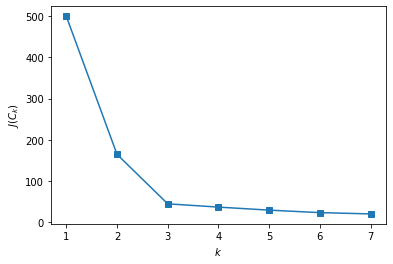

In [17]:
from sklearn.cluster import KMeans

# kmeans.inertia_ -- сумма квадратов расстояний до ближайшего центроида

inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=7).fit(X)
    inertia.append(kmeans.inertia_)
    
plt.plot(range(1, 8), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Видим, что $J(C_k)$ падает сильно при увеличении числа кластеров с 1 до 2 и с 2 до 3 и уже не так сильно – при изменении $k$ с 3 до 4. Значит, в данной задаче оптимально задать 3 кластера.

### Сложности

Само по себе решение задачи `K-means` NP-трудное, и для размерности $d$, числа кластеров $k$ и числа точек $n$ решается за $O(n^{d k+1})$. Для решения такой боли часто используются эвристики, например `MiniBatch K-means`, который для обучения использует не весь датасет целиком, а лишь маленькие его порции (batch) и обновляет центроиды используя среднее за всю историю обновлений центроида от всех относящихся к нему точек. Сравнение обычного `K-means` и его `MiniBatch` имплементации можно посмотреть в документации scikit-learn.

Реализация алгоритма в `scikit-learn` обладает массой удобных плюшек, таких как возможность задать количество запусков через параметр `n_init`, что даст более устойчивые центроиды для кластеров в случае скошенных данных. К тому же эти запуски можно делать параллельно, не жертвуя временем вычисления.

# Метрики качества кластеризации

Выделяют внешние и внутренние метрики качества. Внешние используют информацию об истинном разбиении на кластеры, в то время как внутренние метрики не используют никакой внешней информации и оценивают качество кластеризации, основываясь только на наборе данных. Оптимальное число кластеров обычно определяют с использованием внутренних метрик.

Все указанные ниже метрики реализованы в `sklearn.metrics`.

## Adjusted Rand Index (ARI)

Предполагается, что известны истинные метки объектов. Данная мера не зависит от самих значений меток, а только от разбиения выборки на кластеры. Пусть $N$ - число объектов в выборке. Обозначим через $a$ - число пар объектов, имеющих одинаковые метки и находящихся в одном кластере, через $b$ - число пар объектов, имеющих различные метки и находящихся в разных кластерах. Тогда Rand Index это

$$
\text{RI} = \frac{2(a + b)}{n(n-1)}
$$

То есть это доля объектов, для которых эти разбиения (исходное и полученное в результате кластеризации) "согласованы". Rand Index (RI) выражает схожесть двух разных кластеризаций одной и той же выборки. Чтобы этот индекс давал значения близкие к нулю для случайных кластеризаций при любом $N$ и числе кластеров, необходимо нормировать его. Так определяется Adjusted Rand Index:

$$
\text{ARI} = \frac{\text{RI} - E[\text{RI}]}{\max(\text{RI}) - E[\text{RI}]}
$$

Эта мера симметрична, не зависит от значений и перестановок меток. Таким образом, данный индекс является мерой расстояния между различными разбиениями выборки. $\text{ARI}$ принимает значения в диапазоне $[-1, 1]$. Отрицательные значения соответствуют "независимым" разбиениям на кластеры, значения, близкие к нулю, - случайным разбиениям, и положительные значения говорят о том, что два разбиения схожи (совпадают при $\text{ARI} = 1$).

## Adjusted Mutual Information (AMI)

Данная мера очень похожа на $\text{ARI}$. Она также симетрична, не зависит от значений и перестановок меток. Определяется с использованием функции энтропии, интерпретируя разбиения выборки, как дискретные распределения (вероятность отнесения к кластеру равна доле объектов в нём). Индекс $MI$ определяется как взаимная информация для двух распределений, соответствующих разбиениям выборки на кластеры. Интуитивно, взаимная информация измеряет долю информации, общей для обоих разбиений: насколько информация об одном из них уменьшает неопределенность относительно другого.

Аналогично $\text{ARI}$ определяется индекс $\text{AMI}$, позволяющий избавиться от роста индекса $MI$ с увеличением числа классов. Он принимает значения в диапазоне $[0, 1]$. Значения, близкие к нулю, говорят о независимости разбиений, а близкие к единице - об их схожести (совпадении при $\text{AMI} = 1$).

## Гомогенность, полнота, V-мера

Формально данные меры также определяются с использованием функций энтропии и условной энтропии, рассматривая разбиения выборки как дискретные распределения:

$$
h = 1 - \frac{H(C\mid K)}{H(C)}, c = 1 - \frac{H(K\mid C)}{H(K)}
$$

здесь $K$ - результат кластеризации, $C$ - истинное разбиение выборки на классы. Таким образом, $h$ измеряет, насколько каждый кластер состоит из объектов одного класса, а $c$ - насколько объекты одного класса относятся к одному кластеру. Эти меры не являются симметричными. Обе величины принимают значения в диапазоне $[0, 1]$, и большие значения соответствуют более точной кластеризации. Эти меры не являются нормализованными, как $\text{ARI}$ или $\text{AMI}$, и поэтому зависят от числа кластеров. Случайная кластеризация не будет давать нулевые показатели при большом числе классов и малом числе объектов. В этих случаях предпочтительнее использовать $\text{ARI}$. Однако при числе объектов более 1000 и числе кластеров менее 10 данная проблема не так явно выражена и может быть проигнорирована.

Для учёта обеих величин $h$ и $c$ одновременно вводится $V$-мера, как их среднее гармоническое:

$$
v = 2\frac{hc}{h+c}
$$

Она является симметричной и показывает, насколько две кластеризации схожи между собой.

## Cилуэт

В отличие от описанных выше метрик, данный коэффициент не предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку и результат кластеризации. Сначала силуэт определяется отдельно для каждого объекта. Обозначим через $a$ - среднее расстояние от данного объекта до объектов из того же кластера, через $b$ - среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект). Тогда силуэтом данного объекта называется величина:

$$
s = \frac{b - a}{\max(a, b)}
$$

Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне $[-1, 1]$. Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.

С помощью силуэта можно выбирать оптимальное число кластеров $k$ (если оно заранее неизвестно) - выбирается число кластеров, максимизирующее значение силуэта. В отличие от предыдущих метрик, силуэт зависит от формы кластеров, и достигает больших значений на более выпуклых кластерах, получаемых с помощью алгоритмов, основанных на восстановлении плотности распределения.

### Пример

Давайте посмотрим на эти метрики для `KMeans` и других алгоритмов кластеризации, запущенных на данных рукописных цифр MNIST:

In [ ]:
from sklearn import metrics
from sklearn import datasets
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering


data = datasets.load_digits()
X, y = data.data, data.target

algorithms = []
algorithms.append(KMeans(n_clusters=10, random_state=7))
algorithms.append(AffinityPropagation())
algorithms.append(SpectralClustering(n_clusters=10, random_state=7, affinity='nearest_neighbors'))
algorithms.append(AgglomerativeClustering(n_clusters=10))

data = []
for algo in algorithms:
    algo.fit(X)
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, algo.labels_),
        'AMI': metrics.adjusted_mutual_info_score(y, algo.labels_, average_method='arithmetic'),
        'Homogenity': metrics.homogeneity_score(y, algo.labels_),
        'Completeness': metrics.completeness_score(y, algo.labels_),
        'V-measure': metrics.v_measure_score(y, algo.labels_),
        'Silhouette': metrics.silhouette_score(X, algo.labels_)
    }))

results = pd.DataFrame(
    data=data,
    columns=['ARI', 'AMI', 'Homogenity', 'Completeness', 'V-measure', 'Silhouette'],
    index=['K-means', 'Affinity', 'Spectral', 'Agglomerative']
)

results

# Полезные источники

1. [статья](https://habrahabr.ru/company/io/blog/265089/) "Как подобрать платье с помощью метода главных компонент"
2. [статья](https://habrahabr.ru/users/lexxo/topics/) "Как работает метод главных компонент (PCA) на простом примере"
3. [статья](https://habrahabr.ru/post/321216/) "Интересные алгоритмы кластеризации, часть первая: Affinity propagation"
4. [статья](https://habrahabr.ru/post/322034/) "Интересные алгоритмы кластеризации, часть вторая: DBSCAN"
5. [обзор](http://scikit-learn.org/stable/modules/clustering.html) методов кластеризации в пакете scikit-learn (англ.)
6. [Q&A](http://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues) Разбор PCA с интуицией и примерами (англ.)
7. [тетрадка](https://github.com/diefimov/MTH594_MachineLearning/blob/master/ipython/Lecture10.ipynb) про k-Means и EM-алгоритм в курсе Дмитрия Ефимова (англ.)
8. [конспект](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture12-unsupervised.pdf) "Обучение без учителя" в курсе Евгения Соколова

Материал собран на основе соответствующего занятия в курсе [mlcourse.ai](https://mlcourse.ai/), исходный материал можно найти на [GitHub](https://github.com/Yorko/mlcourse.ai).